<a id="title_ID"></a>
# Astrochemistry Summer School, Groningen 2024 #

**Authors**: Aditya M. Arabhavi, Inga Kamp <br>
If the tools are useful for your science, we kindly ask you to cite the following where relevant:<br>
- [Arabhavi et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024Sci...384.1086A/abstract), for the modeling tools <br>
- [Gordon et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022JQSRT.27707949G/abstract), for the HITRAN spectroscopic data<br>
- [Chown et al. (2023)](https://ui.adsabs.harvard.edu/abs/2024A%26A...685A..75C/abstract'), for the spectrum of PDR <br>
- [Grant et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023ApJ...947L...6G/abstract'), for the spectrum of GW Lup <br>
- [Arabhavi et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024Sci...384.1086A/abstract'), for the spectrum of ISO-ChaI 147<br>


**Contact**: arabhavi@astro.rug.nl or kamp@astro.rug.nl
<br>
**Last Update**: 22 August 2024
<br>
**Compatible prodimopy versions**: >= 2.3.1

**Table of contents**
* [0. Imports and setup](#0.-Imports-and-setup)
* [1. Understanding molecular spectra](#1.-Understanding-molecular-spectra)
    - [1.1. Task 1](#1.1.-Task-1)
    - [1.2. Task 2](#1.2.-Task-2)
* [2. Observations](#2.-Observations)
    - [2.0. Some atomic and molecular spectroscopic data](#2.0.-Some-atomic-and-molecular-spectroscopic-data)
    - [2.1. A photon-dominated region (PDR)](#2.1.-A-photon-dominated-region-(PDR))
        - [2.1.1. Task 3](#2.1.1.-Task-3)
        - [2.1.2. Task 4](#2.1.2.-Task-4)
    - [2.2. Planet-forming regions](#2.2.-Planet-forming-regions)
        - [2.2.1. GW Lup](#2.2.1.-GW-Lup)
            - [2.2.1.1. Task 5](#2.2.1.1.-Task-5)
        - [2.2.2. ISO-ChaI 147](#2.2.2.-ISO-ChaI-147)
            - [2.2.2.1 Task 6](#2.2.2.1-Task-6)

# 0. Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prodimopy.read_slab as rs
import prodimopy.plot_slab as ps
import prodimopy.run_slab as runs
import prodimopy.hitran as ht
import matplotlib as mpl
from scipy.constants import c,k,h
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
# from mpl_point_clicker import clicker
from scipy.interpolate import CubicSpline
import pybaselines as pb
from spectres import spectres
import scipy as sp
%matplotlib notebook
from os.path import join
import pandas as pd

# Use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# 1. Understanding molecular spectra

<img style="float: left; padding-right:1%" src='https://phys.libretexts.org/@api/deki/files/10010/CNX_UPhysics_42_02_Trans.jpg?revision=1' alt="Rovib" width="25%"/> 
The figure on the left shows the different energy levels that can be occupied by a molecule. Each level is identified by a combination of quantum numbers. You can this of this like an address of a molecular state. Like having multiple buildings in a street, and multiple apartments within a building, each electronic state can have multiple vibrational energy levels, and each vibrational level can have multiple rotational levels.<br>
The energy difference between the electronic states are higher than the energy difference between the vibrational states, which is higher than the difference between the rotational states <br> <br>
ΔE<sub>elec</sub>>ΔE<sub>vib</sub>>ΔE<sub>rot</sub><br><br>
A molecular energy transition is defined as a change in the energy level of a molecule from one 'address' to another 'address'. Let's call them E<sub>u</sub> and E<sub>l</sub>, for the upper and lower energy levels. The net change in the energy (ΔE<sub>ul</sub>) is E<sub>u</sub>-E<sub>l</sub> for a transition from upper to lower energy level. This change in energy is released in the form of a single photon whose frequency can be defined as 𝜈<sub>ul</sub>=ΔE<sub>ul</sub>/h (where h is the planck's constant).<br>

However, in reality we do not observe the transition of a single molecule in space, but a transitions of several molecules in a given line of sight. That is, we observe multiple molecules transitioning from energy level A to B, another set of molecules from A to C, another set from B to C, etc. Each set here would correspond to different frequency, which gives rise to the fingerprints of the molecules, or the molecular spectra. To calculate the molecular emission or absorption spectrum, we need a few ingredients: <br>
&nbsp;&nbsp;&nbsp;   1. the energy of each level, e.g., E<sub>1</sub>, E<sub>2</sub>, ..., E<sub>n</sub> for 'n' levels.<br>
&nbsp;&nbsp;&nbsp;   2. the population or the number of molecules in each 'address' or energy level.<br>
&nbsp;&nbsp;&nbsp;   3. probability of transition by photon emission/absorption from one energy level to the other, called the Einstein A coefficient: A<sub>ul</sub>, for a transition from energy state u to l.<br>
&nbsp;&nbsp;&nbsp;   4. denegeracy of the energy level or number of duplicate addresses.<br>
Part of these ingredients (particularly 1,3,4) can be obtained from different databases that either provide these based on quantum chemistry calculations or laboratory measurements. For the purposes of this exercise we will use the data from the <a href="https://hitran.org/">HITRAN spectroscopic database</a>.<br>
You can find the HITRAN spectroscopic data of several molecules in <code>astrochemschool2024/src/data/hitran/</code>.<br>
In local thermodynamic equlibrium (LTE), we can assume that the population (p) of the energy levels follow the <a href="https://en.wikipedia.org/wiki/Boltzmann_distribution">Boltzmann distribution</a>. To calculate this, we need the energy (E) and degeneracy (g) of each level, the temperature (T) of the molecules and the partition sums (Q). Latter is provided in the database.<br>
$$p = \frac{g\ e^{-E/T}}{Q} $$

Let us read in some data from HITRAN and build our own molecular spectra!<br>
Take a look at the list of molecules at <code>astrochemschool2024/src/data/hitran/</code> and pick your favorite.

In [2]:
molecule = 'H2O' # use the exact name as provided in the hitran directory
mol_mas = 18 # you need to know/find the molecular mass in atomic mass units. If you are not sure, search online or use online tools such as https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm
temperature = 300 # in Kelvin
isotopologue = [1] # let us select only the main isotopologue of the molecule

# Do not change the below code unless you know exactly what you are doing
filepath = '../src/data/hitran/'+molecule+'.par'
QTpath = '../src/data/QTpy/'

In [3]:
mol_data = ht.read_hitran(filepath,
                          molecule,
                          isotopologue,
                          lowerLam=16, higherLam=18) # wavelength limits in microns

Use <code>mol_data.keys()</code> in a separate cell, to see different columns of the data. In the following we only include the relevant ones

In [4]:
include = ['lambda','A','E_u','E_l','global_u','global_l','local_u','local_l','g_u','g_l']
mol_data[include]

,lambda,A,E_u,E_l,global_u,global_l,local_u,local_l,g_u,g_l
22747,16.000010,2.869000e-01,5132.522307,4507.5227,0 1 0,0 1 0,15 6 10,15 3 13,31.0,31.0
22746,16.004690,1.002000e+02,4796.969164,4172.1523,0 0 0,0 0 0,15 12 3,14 11 4,93.0,87.0
22745,16.004690,1.002000e+02,4796.969159,4172.1523,0 0 0,0 0 0,15 12 4,14 11 3,31.0,29.0
22742,16.011221,5.829000e+01,4830.893873,4206.3319,0 0 0,0 0 0,17 9 8,16 8 9,105.0,99.0
22738,16.016349,2.505000e-01,5442.097824,4817.7358,0 0 1,0 0 1,10 5 5,9 2 8,63.0,57.0
...,...,...,...,...,...,...,...,...,...,...
21726,17.968006,6.411000e-03,4889.457083,4332.9123,1 0 0,0 0 1,8 5 4,7 1 7,51.0,45.0
21724,17.970464,6.227000e-05,3997.508257,3441.0396,0 1 0,0 1 0,10 8 3,11 3 8,63.0,69.0
21720,17.978484,1.169000e-08,2246.884827,1690.6644,0 0 0,0 0 0,13 2 11,11 2 9 q,81.0,69.0
21714,17.994847,1.505000e-03,4847.622151,4291.9075,0 1 0,0 0 0,16 3 14,17 6 11,99.0,105.0


Here each row corresponds to a line transition of your favorite molecule. 'lambda' is the wavelength \[microns\], 'A' is the Einstein A coefficient \[s<sup>-1</sup>\], 'E_u', 'E_l' are the upper and lower energy levels \[cm<sup>-2</sup>\], 'global_u', 'global_l' are the quantum numbers (addresses) of the vibrational levels, 'local_u', 'local_l' are the quantum numbers of the rotational levels, 'g_u', 'g_l' are the degeneracies of the upper and lower energy levels.<br><br>
Let us visualize this by plotting the upper energy levels against the wavelength, colored by the Einstein A coefficients. What do you observe?

<IPython.core.display.Javascript object>


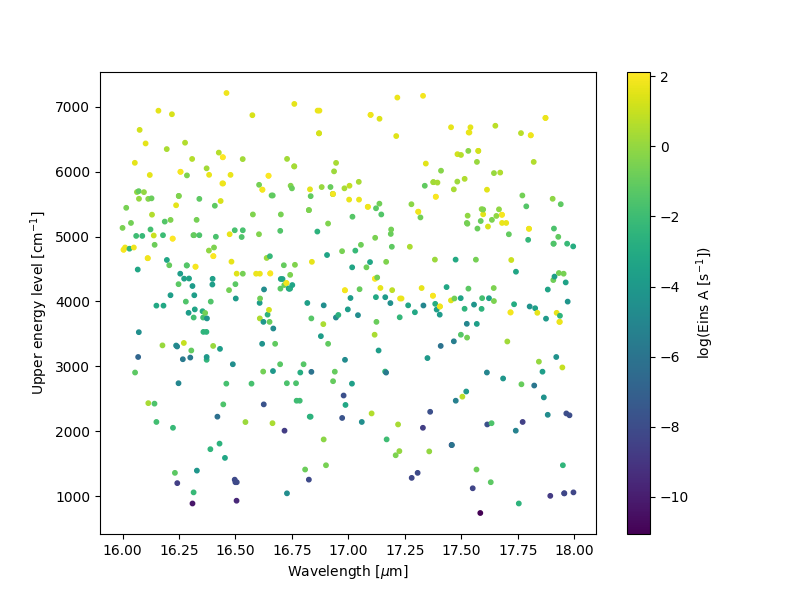

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [5]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],mol_data['E_u'],c=np.log10(mol_data['A']),s=10)
cbar = fig.colorbar(A,label='log(Eins A [s$^{-1}$])')
ax.set_ylabel('Upper energy level [cm$^{-1}$]')
ax.set_xlabel('Wavelength [$\mu$m]')


We can visualize the upper and lower energy levels together also illustrating the level transition:

<IPython.core.display.Javascript object>


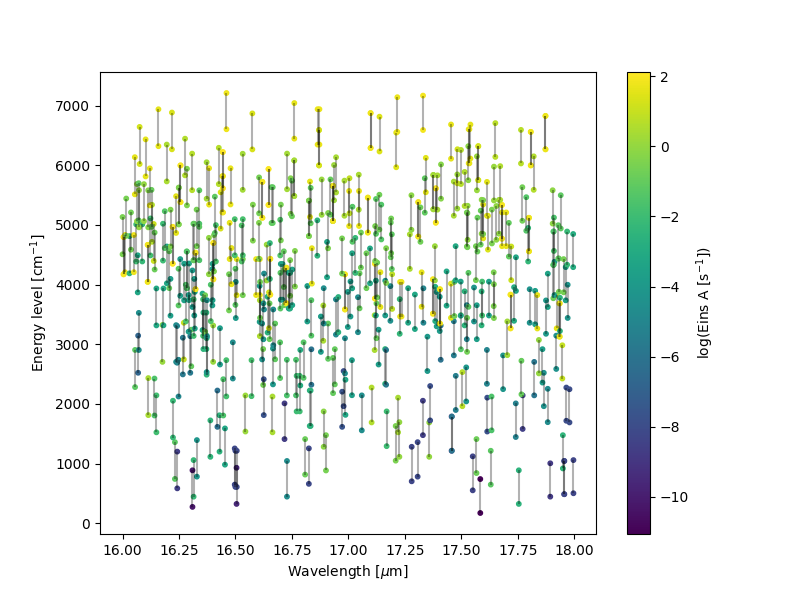

Text(0.5, 0, 'Wavelength [$\\mu$m]')

In [6]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],mol_data['E_u'],c=np.log10(mol_data['A']),s=10)
ax.scatter(mol_data['lambda'],mol_data['E_l'],c=np.log10(mol_data['A']),s=10)
ax.vlines(mol_data['lambda'],mol_data['E_l'],mol_data['E_u'],color='k',alpha=0.3)
cbar = fig.colorbar(A,label='log(Eins A [s$^{-1}$])')
ax.set_ylabel('Energy level [cm$^{-1}$]')
ax.set_xlabel('Wavelength [$\mu$m]')


Let us now calculate the level populations

In [7]:
upper_level_population = runs.boltzmann_distribution(mol_data['E_u'],mol_data['g_u'],temperature,runs.fetch_QT(molecule,isotopologue[0],temperature,QTpath))
lower_level_population = runs.boltzmann_distribution(mol_data['E_l'],mol_data['g_l'],temperature,runs.fetch_QT(molecule,isotopologue[0],temperature,QTpath))

Visualize the upper level populations, colored by the energy of those levels. **What do you observe?**<br>
If you color them by the Einstein A coefficients, **what do you see?**<br>
How would the figure change for lower and higher temperatures? 

<IPython.core.display.Javascript object>


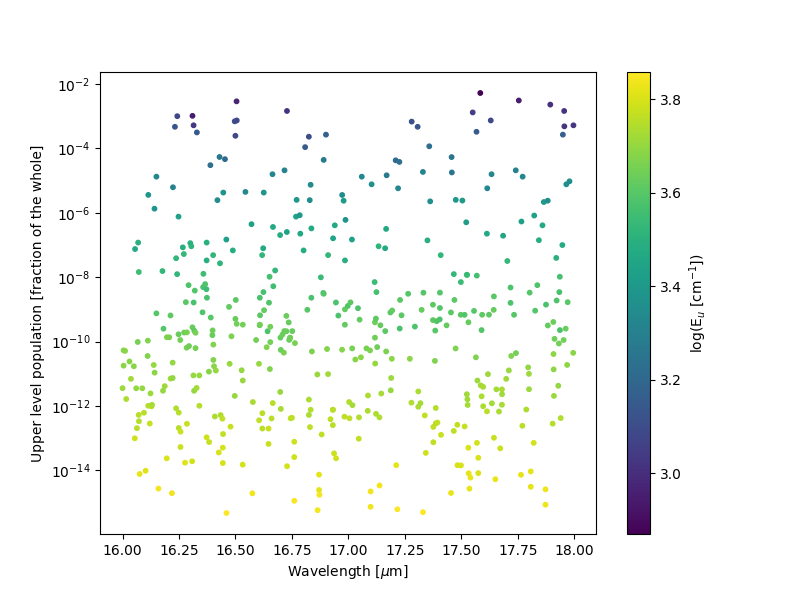

In [8]:
fig,ax = plt.subplots(figsize=(8,6))
A = ax.scatter(mol_data['lambda'],upper_level_population,c=np.log10(mol_data['E_u']),s=10)
cbar = fig.colorbar(A,label='log(E$_u$ [cm$^{-1}$])')
ax.set_ylabel('Upper level population [fraction of the whole]')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_yscale('log')

We are two more steps away from calculating the line intensities or the spectrum. We need to understand the line profile function and the line optical depth.<br>
**Line profile function**: In a gas of kinetic temperature T, the molecules have a large distribution of kinetic energies. i.e., the kinetic temperature represents the mean kinetic energy of the system. Due to this, instead of each molecular transition between E<sub>1</sub> and E<sub>2</sub> having the energy difference of E<sub>u</sub>-E<sub>l</sub> at $\nu_{12}$, there will be a slight variation in these frequencies. For simplicity, we can assume that this distribution is Gaussian in LTE. This means that instead of all transitions emitting at the frequency $\nu_{12}$, the lines follow a Gaussian profile (the line profile function $\phi$) with the mean at $\nu_{12}$ and width $\Delta\nu_D$<br>
$$\phi_{\nu} = \frac{1}{\Delta\nu_{D}\sqrt{\pi}}e^{-\left(\frac{\nu-\nu_{12}}{\Delta\nu_D}\right)}$$
**Line optical depth**: As the number of molecules increase, the number of photons released also increase. However, as the number of molecules in the line of sight increase, there will be inter-molecular absorption of the photons. Due to this only a fraction of the emitted photon actually escape towards the observer. This can be quantified by the captured by calculating the quantity known as optical depth $\tau$. The optical depth at the line center for a column of N molecules per cm$^{-2}$ is given by:
$$\tau_{12}=\frac{N\lambda_{12}^2A_{12}}{8\pi}\left(\frac{g_1}{g_2}p_2-p_1\right)$$
Combining these two, we can write the optical depth at any frequency $\nu$ due to the transition between energy levels 1 to 2 as:
$$\tau_{\nu}=\frac{\tau_{12}}{\Delta\nu_D\sqrt{\pi}}e^{-\left(\frac{\nu-\nu_{12}}{\Delta\nu_D}\right)}$$
<br><br>
Using the radiative transfer equation $\frac{dI_{\nu}}{ds}=j_{\nu}-\kappa_{\nu}J_{\nu}$ ($I_{\nu}$ is the specific intensity, $s$ is the direction, $j_{\nu}$ and $\kappa_{\nu}$ are the emission and absorption coefficients), we can show that the total line intensity ($I$) is given by
$$I = B_{\nu_{12}}(T)C$$
where $B_{\nu_{12}}(T)$ is the Planck function at temperature $T$, and $C$ is the growth factor given by $\int\left(1-e^{-\tau_{\nu}}\right)d\nu$<br>
Below figures show how the factor $1-e^{-\tau_{\nu}}$ which encapsulates the optical depth and the line profile function


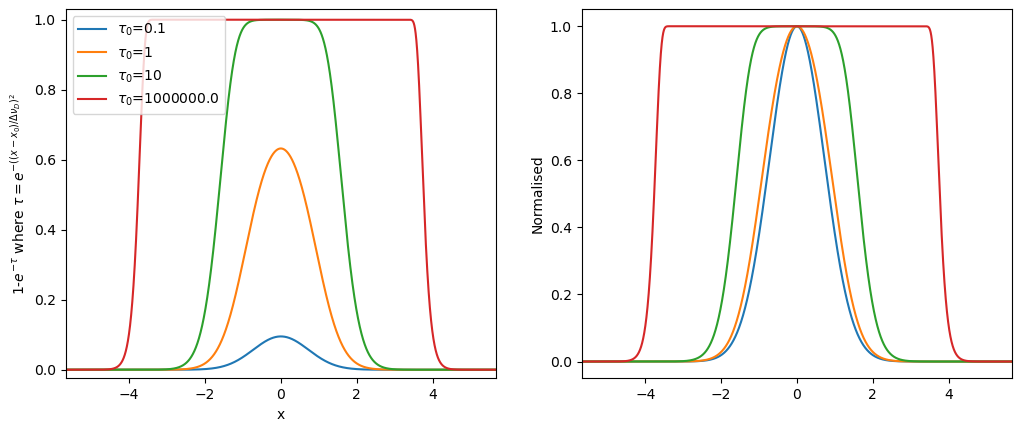

As the optical depth at the line center increases, the factor $1-e^{-\tau_{\nu}}$ increases, and the profile gets broader. At large optical depths, the line center saturates, meaning the line intensity at the line center equals the Planck function (or the blackbody curve). As the opacity increases to even larger values, the line profile becomes even more 'square' shaped.<br>
The integral of this factor, i.e., the growth factor $\int\left(1-e^{-\tau_{\nu}}\right)d\nu$ continues to grow with optical depth, but at a much shallower rate than linear (see below). i.e., as the number of molecules in the line of sight increases, the optical depth increases. At low optical depths, the increase in number of molecules directly increases the line flux; but as the optical depth saturates the line flux increases but much slowly. **Can you explain why the growth factor increases with the optical depth even when the optical depth at the line center saturates pretty quickly?**

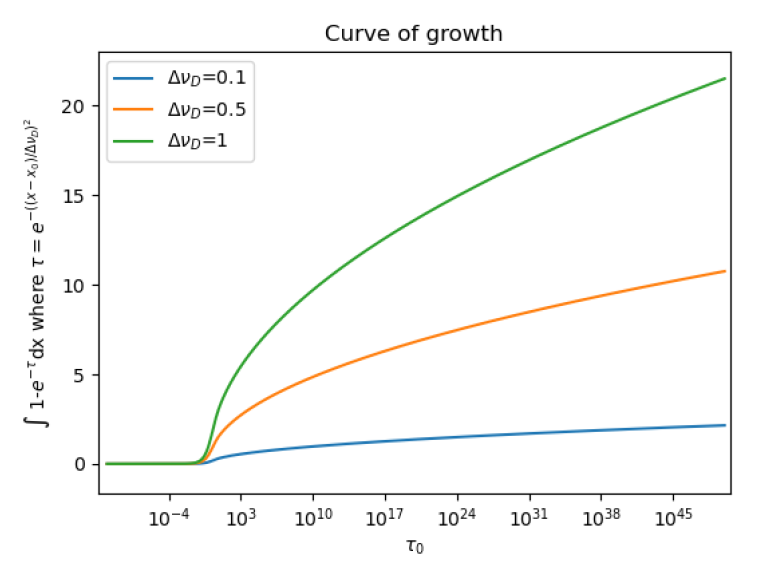

Now that we have all the ingredients, let us calculate the line fluxes of your favorite molecule. We have already implemented all of the above equations into the function <code>prodimopy.runs_slab.run_0d_slab</code>. The following block of code is self-explanatory. The output of the model is stored in <code>outputfile</code>

In [9]:
data = runs.run_0D_slab(Ng         = 1e18,            # The gas column density in molecules per cm2
                        Tg         = temperature,     # The gas temperature
                        vturb      = 2.0,             # Delta nu_D or the width parameter in km/s
                        molecule   = molecule,        # name of the molecule
                        mol_mass   = mol_mas,         # molecular mass in amu
                        HITRANfile = filepath,        # Path of the HITRAN data file
                        QTpath     = QTpath,          # path of the partition sums
                        isotopolog = isotopologue,    # list of isotopologues to include      
                        wave_mol   = [16,18],         # wavelength region in which the lines are to be picked up
                        mode       = 'line_by_line',  # "line-by-line" calculation, or include mutual "overlap"
                        output     = 'return')        # "return" data or write to "file" or do "both"

The line intensities are now calculated.<br>

If you choose to read the model from a file, instead, then run the following code in a new cell to read the output file.

<code>data = rs.read_slab("outputfilename")</code>

<code>data</code> now contains the output data. This includes the level data <code>data.leveldata</code> (levels, the level energies, the level populations), and the line data <code>data.linedata</code> (the levels involved in each transition, the level quantum numbers, the optical depths of the line centers, the total line intensities for each transition, etc.). The unit of the total line intensities is erg/s/cm$^{2}$/sr.<br>
You can use the <code>.keys()</code> method to see the other columns that might interest you. Below we show only a few that are relevant for this exercise.

In [10]:
data.leveldata[['g','E','ltepop']]

,g,E,ltepop
0,31.0,5132.522307,3.551485e-12
1,31.0,4507.522700,7.115182e-11
2,93.0,4796.969164,5.326424e-11
3,87.0,4172.152300,9.973955e-10
4,31.0,4796.969159,1.775475e-11
...,...,...,...
903,69.0,1690.664400,1.166129e-04
904,99.0,4847.622151,4.447191e-11
905,105.0,4291.907500,6.778072e-10
906,15.0,1059.646657,5.227567e-04


In [11]:
data.linedata[['Eu','A','GHz','tauLTE','FLTE','global_u', 'global_l', 'local_u', 'local_l']]

,Eu,A,GHz,tauLTE,FLTE,global_u,global_l,local_u,local_l
0,5132.522307,2.869000e-01,18737.016843,8.622798e-09,1.006760e-08,0 1 0,0 1 0,15 6 10,15 3 13
1,4796.969164,1.002000e+02,18731.538346,4.516390e-05,5.269395e-05,0 0 0,0 0 0,15 12 3,14 11 4
2,4796.969159,1.002000e+02,18731.538196,1.505463e-05,1.756578e-05,0 0 0,0 0 0,15 12 4,14 11 3
3,4830.893873,5.829000e+01,18723.896906,2.520792e-05,2.940165e-05,0 0 0,0 0 0,17 9 8,16 8 9
4,5442.097824,2.505000e-01,18717.902586,3.466083e-09,4.043546e-09,0 0 1,0 0 1,10 5 5,9 2 8
...,...,...,...,...,...,...,...,...,...
449,4889.457083,6.411000e-03,16684.792848,1.016058e-09,1.057465e-09,1 0 0,0 0 1,8 5 4,7 1 7
450,3997.508257,6.227000e-05,16682.510648,8.786966e-10,9.143710e-10,0 1 0,0 1 0,10 8 3,11 3 8
451,2246.884827,1.169000e-08,16675.068900,9.393303e-10,9.769689e-10,0 0 0,0 0 0,13 2 11,11 2 9 q
452,4847.622151,1.505000e-03,16659.906117,5.660000e-10,5.880880e-10,0 1 0,0 0 0,16 3 14,17 6 11


You can manually plot the line intensities with wavelength on x-axis by converting the frequencies in GHz to microns, and the line intensities on the y-axis. Or you can also use the pre-built <code>prodimopy.plot_slab.plot_lines()</code> function.

**Option: pre-build function**

<IPython.core.display.Javascript object>


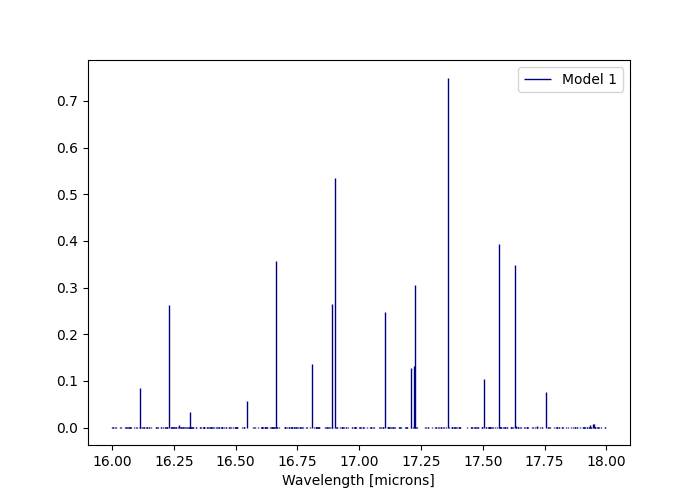

[(<Figure size 700x500 with 1 Axes>, <Axes: xlabel='Wavelength [microns]'>)]

In [12]:
ps.plot_lines(data,label=['Model 1'])

**Option: manual**

<IPython.core.display.Javascript object>


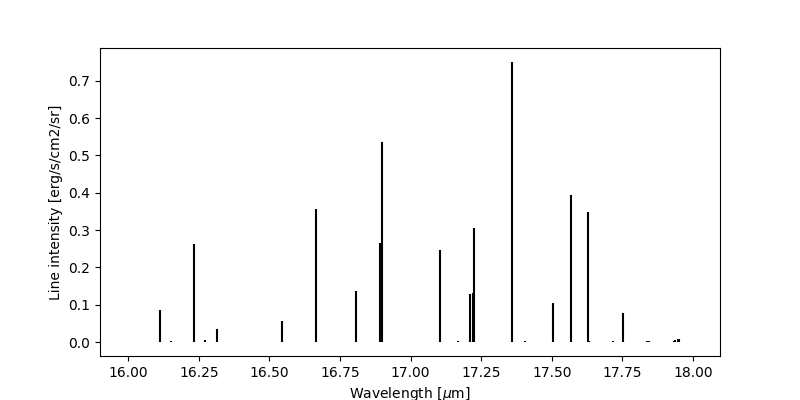

Text(0, 0.5, 'Line intensity [erg/s/cm2/sr]')

In [13]:
fig,ax = plt.subplots(figsize=(8,4))

wavelengths = c/data.linedata['GHz']*1e-3 # Convert GHz to microns, c is the speed of light

ax.vlines(wavelengths,0,data.linedata['FLTE'],color='k',label='Model 1')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Line intensity [erg/s/cm2/sr]')

We next convolve these line intensities on to a wavelength grid that is similar to the spectroscopy tools used to observe the astrophysical environments. Below we convolve the spectra at a spectral resolving power R=3000, representative of the Mid-infrared instrument (MIRI) on the James Webb Space Telescope (JWST). The resulting spectrum will provide the specific intensity (not the total or integrated line intensity) with the units erg/s/cm$^2$/sr/Hz.

In [14]:
data.convolve(R=3000,lambda_0=16,lambda_n=18)


 1 ; Model number  1 ; Species number  1


**Option: pre-build function** <code>prodimopy.plot_slab.plot_spectra()</code>

<IPython.core.display.Javascript object>


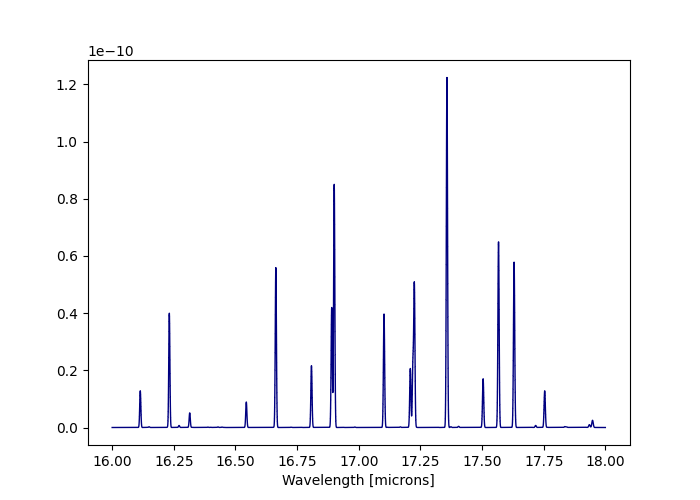

[(<Figure size 700x500 with 1 Axes>, <Axes: xlabel='Wavelength [microns]'>)]

In [15]:
ps.plot_spectra(data)

**Option: manual**

<IPython.core.display.Javascript object>


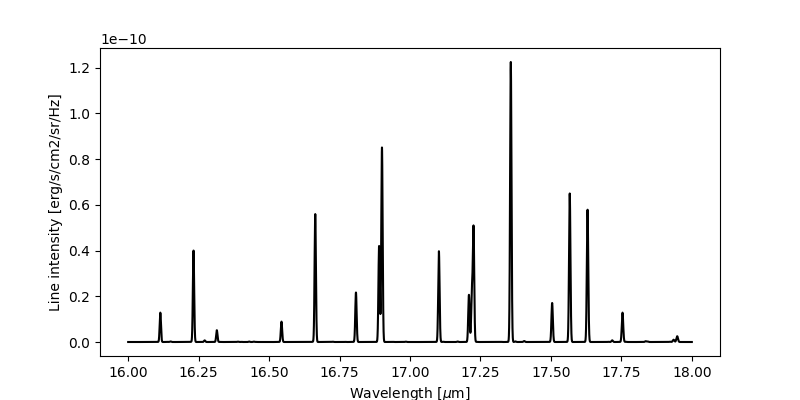

Text(0, 0.5, 'Line intensity [erg/s/cm2/sr/Hz]')

In [16]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(data.convWavelength,data.convLTEflux,color='k',label='Model 1')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Line intensity [erg/s/cm2/sr/Hz]')

## 1.1. Task 1
Calculate the line fluxes for temperatures of 100, 200, 300, 400, 500 K at a column density of $\rm10^{18}\ cm^{-2}$. Read them using the pre-built function as shown before. Convolve the lines to a resolving power of $R=3000$. Normalize the spectra to their peak intensities and plot them in a single window with different colors and labels. Explain the differences observed in these spectra. 

Note: you can read in multiple slab models in a single function call by passing a <code>list</code> of strings containing the file paths. e.g., <code>data = rs.read_slab(['file1.out','file2.out','file3.out'])</code><br>
You can then access individual slab models by <code>data[0]</code>, <code>data[1]</code>, <code>data[2]</code><br>
<code>data.convolve()</code> function will convolve all the slab models with the same settings that you pass. <code>plot_lines</code> and <code>plot_spectra</code> plot all models. To normalise the spectra, and plot in single window see possible arguments that can be passed using the <code>help()</code> function.

## 1.2. Task 2

Repeat the same exercise as Task 1, but with a constant temperature of 300 K, while varying the column density from $\rm10^{16}-10^{20}\ cm^{-2}$.

# 2. Observations

We observe emission from dust, atoms, and molecules from several astrophysical environments, such as <a href="https://en.wikipedia.org/wiki/Interstellar_medium"> interstellar medium</a>, <a href="https://en.wikipedia.org/wiki/Molecular_cloud">molecular clouds</a>, <a href="https://en.wikipedia.org/wiki/Protoplanetary_disk">planet-forming disks around stars</a>, etc.<br><br>
These environments widely vary in their chemical composition and the physical conditions. These molecular and atomic emissions are great tools to probe the conditions in those environments.<br><br>
In this section, we will take a look at some of these emission in the mid-infrared wavelengths, observed by the Mid-InfraRed Instrument (MIRI) on the James Webb Space Telescope (JWST). First, we will attempt to identify the molecular/atomic emission features in the observed spectra, and then make simple attempts to get a feel for the physical conditions in those environments. These observations are also a playground to test whether the tools/models that we have developed so far are robust.

## 2.0. Some atomic and molecular spectroscopic data

For simple cases such as atomic hydrogen, we can use a simple relation to calculate the wavelength ($\lambda$) at which different transitions ($n_2->n_1$) appear in the spectra called the <a href="https://en.wikipedia.org/wiki/Rydberg_formula">Rydberg formula</a>:<br>
$$\frac{1}{\lambda}=RZ^2\left(\frac{1}{n_1^{2}}-\frac{1}{n_2^{2}}\right)$$
Here, $Z$ is the atomic number, and $R$ is the Rydberg's constant ($\approx1.09677583\times10^7$ m$^{-1}$).<br>

We implement the above equation in the below function to calculate the wavelengths in micrometers.

In [17]:
def atomic_lines(Z,n1,n2):
    R = 1.09677583e7
    one_over_lambda = R*Z**2*(1/n1**2-1/n2**2)
    return(1/(one_over_lambda)*1e6) # convert to micrometers

For the other atoms and H$_2$ molecule, we use the line list measured from laboratory, since it is quite complex to do that here.

In [18]:
H2mol = pd.read_csv('../src/data/H2_lines.csv')
atomic = pd.read_csv('../src/data/atomic_lines.csv')

In [19]:
H2mol
# vu and vl is the upper and lower vibrational levels
# Ju and Jl are the upper and lower rotational levels
# lambda is the wavelength in microns
# sigma is the wavenumber in cm-1
# A, Eu, and gu are the Einstein A coefficient of the line transition, the energy and generacy of the upper level
# you can access each column by H2mol['column name in quotes'], e.g. H2mol['lambda'] gives the wavelengths. H2mol['lambda'].iloc[i] returns the wavelength in the 'i'th row

,vu,Ju,vl,Jl,sigma,Dsigma,lambda,Dlambda,Aqua,Ama,A,Atot,Eu,DEu,Tu,gu
0,0,2,0,0,354.373130,3.700000e-06,28.218844,2.900000e-07,2.943000e-11,0.0,2.943000e-11,2.943000e-11,-35763.696396,0.000230,509.9,5
1,0,3,0,1,587.032025,6.100000e-06,17.034846,1.800000e-07,4.761000e-10,0.0,4.761000e-10,4.761000e-10,-35412.550688,0.000230,1015.1,21
2,0,4,0,2,814.424302,8.400000e-06,12.278612,1.300000e-07,2.755000e-09,0.0,2.755000e-09,2.755000e-09,-34949.272093,0.000220,1681.6,9
3,0,5,0,3,1034.670685,1.100000e-05,9.664911,1.000000e-07,9.836000e-09,0.0,9.836000e-09,9.836000e-09,-34377.880003,0.000220,2503.7,33
4,0,6,0,4,1246.099547,1.300000e-05,8.025041,8.400000e-08,2.643000e-08,0.0,2.643000e-08,2.643000e-08,-33703.172546,0.000210,3474.5,13
5,0,7,0,5,1447.280936,1.400000e-05,6.909509,6.700000e-08,5.879000e-08,0.0,5.879000e-08,5.879000e-08,-32930.599067,0.000200,4586.1,45
6,0,8,0,6,1637.046000,1.600000e-05,6.108564,6.000000e-08,1.142000e-07,0.0,1.142000e-07,1.142000e-07,-32066.126547,0.000200,5829.8,17
7,0,9,0,7,1814.492375,1.700000e-05,5.511183,5.200000e-08,2.001000e-07,0.0,2.001000e-07,2.001000e-07,-31116.106692,0.000190,7196.7,57
8,0,10,0,8,1978.977263,1.900000e-05,5.053115,4.900000e-08,3.236000e-07,0.0,3.236000e-07,3.236000e-07,-30087.149284,0.000180,8677.1,21
9,0,28,1,26,354.175248,7.200000e-06,28.234610,5.700000e-07,1.764000e-11,0.0,1.764000e-11,5.506000e-06,-5120.547864,0.000008,44598.5,57


In [20]:
atomic
# first column contains the element/atom corresponding to the line transition
# lambda is the wavelength in microns
# J_i and J_k are the lower and upper level quantum numbers
# E_i(cm-1) and Ek(cm-1) are the lower and upper level energies
# you can access each column by atomic['column name in quotes'], e.g. atomic['lambda'] gives the wavelengths. atomic['lambda'].iloc[i] returns the wavelength in the 'i'th row
# you can select lines of one or more elements using masks, see for example: https://stackoverflow.com/questions/38802675/create-bool-mask-from-filter-results-in-pandas

,element,sp_num,lambda,intens,Aki(s^-1),S(a.u.),Acc,Ei(cm-1),Ek(cm-1),conf_i,term_i,J_i,conf_k,term_k,J_k,line_ref
0,Xe,1,4.90282,1*,NaN,NaN,NaN,95196.5300,97236.276,5p5.(2P*<3/2>).10p,2[5/2],3,5p5.(2P*<3/2>).16d,2[7/2]*,3,L1975
1,Xe,1,4.90282,1*,NaN,NaN,NaN,94685.4670,96725.3,5p5.(2P*<3/2>).8d,2[3/2]*,1,5p5.(2P*<3/2>).10f,2[3/2],2,L1975
2,Xe,1,4.90282,1*,NaN,NaN,NaN,94787.0840,96827.0,5p5.(2P*<3/2>).10s,2[3/2]*,1,5p5.(2P*<3/2>).14p,2[5/2],2,L1975
3,Ne,1,4.90451,20,NaN,NaN,NaN,167449.4698,169488.4193,2s2.2p5.(2P*<3/2>).5p,2[1/2],1,2s2.2p5.(2P*<3/2>).5d,2[1/2]*,1,L1975
4,Xe,1,4.90521,2,NaN,NaN,NaN,92721.5300,94759.935,5p5.(2P*<3/2>).7d,2[3/2]*,2,5p5.(2P*<3/2>).6f,2[5/2],2,L1975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,H,1,19.06196,540,227200.000000,99258.000,AAA,107440.4508,107965.0568,7,NaN,NaN,8,NaN,NaN,L7455
321,Ar,3,21.83020,NaN,0.005190,2.000,A,1112.1700,1570.23,3s2.3p4,3P,1,3s2.3p4,3P,0,L13330
322,Fe,3,22.92500,NaN,0.002884,9.036,AA,0.0000,436.19,3d6,5D,4,3d6,5D,3,L7250
323,Ne,5,24.31750,NaN,0.001290,2.050,B,0.0000,411.227,2s2.2p2,3P,0,2s2.2p2,3P,1,L11744


The list of atoms included in this list are: 

In [21]:
list(set(atomic['element']))

['Cr',
 'Th',
 'Ar',
 'H',
 'Kr',
 'S',
 'Al',
 'Zn',
 'Hg',
 'Fe',
 'K',
 'C',
 'Ti',
 'Mg',
 'Cu',
 'F',
 'Ne',
 'Xe',
 'Na']

## 2.1. A photon-dominated region (PDR)
<a href="https://en.wikipedia.org/wiki/Photodissociation_region">PDRs</a> are regions in the interstellar medium, where the interstellar radiation, mainly the ultra-violet photons, have a strong influence on the chemistry and energy of the region.

The JWST program <a href='https://pdrs4all.org/'>PDRs4All</a>, observed such regions (<a href='https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1288'>ID:1288</a>). We use one of the spectrum from this program <a href='https://ui.adsabs.harvard.edu/abs/2024A%26A...685A..75C/abstract'>(Chown et al. 2023)</a>.

In [22]:
spectra = np.loadtxt('../src/data/observations/PDR.dat')
wavelength = spectra[:,0]
flux       = spectra[:,1]
continuum  = spectra[:,2]

For this exercise, we are interested in the atomic and molecular emission, not so much about the dust. Generally, dust emits as a blackbody when it is dense, and can also show some optically thin features in the spectra, otherwise. Here, we refer to PAHs, refractory solids, together as dust, and it's emission as 'continuum'.<br>
To analyse the atomic and molecular emission in the spectra, we would like to remove the contribution from dust (continuum).



<IPython.core.display.Javascript object>


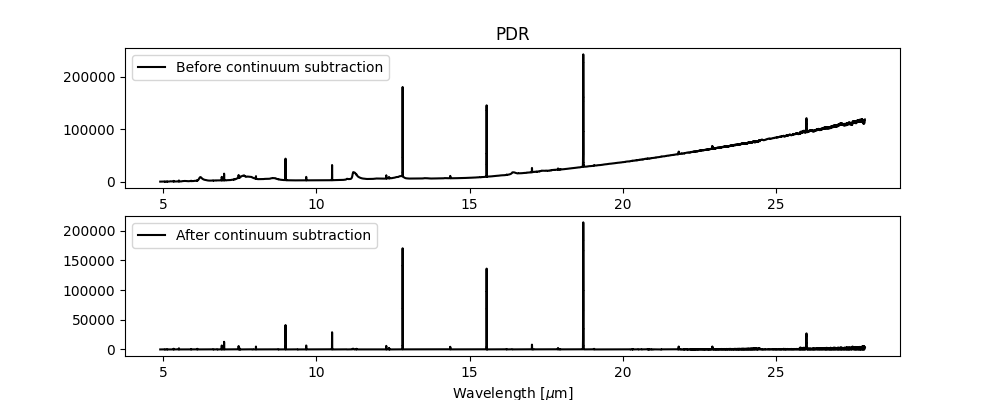

Text(0.5, 1.0, 'PDR')

In [23]:
fig,ax = plt.subplots(2,1,figsize=(10,4))

ax[0].step(wavelength,
           flux,
           where='mid',color='k',label='Before continuum subtraction')
ax[0].legend(loc='upper left')
ax[1].step(wavelength,
           flux-continuum,
           where='mid',color='k',label='After continuum subtraction')
ax[1].legend(loc='upper left')
ax[1].set_xlabel('Wavelength [$\mu$m]')
ax[0].set_title('PDR')

Zoom in and take a closer look at the bottom panel. There are several spikes of varying strengths, these are mostly atomic and molecular line emissions. Now let us investigate them using the line lists and Rydberg's formula.<br>

The easiest way to identify the lines are by plotting vertical lines across the figure at each line position and then plot the observed spectrum on top. We use the spectrum after subtraction of the continuum.

<IPython.core.display.Javascript object>


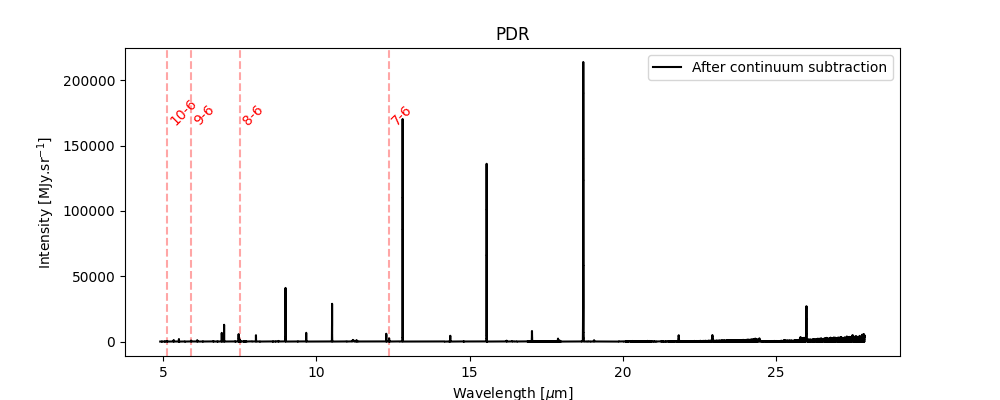

Text(0.5, 1.0, 'PDR')

In [24]:
fig,ax = plt.subplots(figsize=(10,4))

trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes) # settings to fix the text y-position wrt the figure size

# Let us plot all atomic hydrogen lines i->j, j=6, i = 25,24,...,7, using Rydberg's formula

j = 6
for i in range(7,25):
    w = atomic_lines(1,6,i)
    if w>4.9 and w<28: # we plot only if the line falls in the wavelength range of the observed spectra
        ax.axvline(w,linestyle='dashed', alpha=0.35, color = 'r')
        ax.text(w,0.75,f'{i}-{j}',transform=trans,rotation=45,color='r')

# plot the observation on top

ax.step(wavelength,
           flux-continuum,
           where='mid',color='k',label='After continuum subtraction')
ax.legend(loc='upper right')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Intensity [MJy.sr$^{-1}$]')
ax.set_title('PDR')

### 2.1.1. Task 3
Investigate which other series of atomic hydrogen transitions are present in the above spectrum. Upto what upper level quantum number are the lines observed for each transition set i->j?

### 2.1.2. Task 4
Now using the <code>H2mol</code> and <code>atomic</code> datasets, investigate which atomic lines and H$_2$ lines are present in the spectrum.
With these investigations, are you able to identify all the lines observed? if not which specific lines (wavelengths) are not identified with an emission in the list (or with atomic hydrogen lines)?
Can you speculate or find on the internet what these lines could be? Discuss with your peers.

## 2.2. Planet-forming regions
<a href='https://en.wikipedia.org/wiki/Protoplanetary_disk'>Planet-forming regions or protoplanetary disks</a> are disks of gas and dust around a young star, that has formed from the collapsing molecular cloud during the star formation. It is within these disks that planets form. Earth, and the other planets in our solar system, as well as other bodies such as asteroids, comets, and other minor bodies trace their origin to a protoplanetary disk around the young Sun, right after the Sun formed. These disks are expected to typically last for a few million years, for context the age of the Solar system is estimated to be about 4.5 billion years.<br>

The composition of these disks unravel the ingredients that goes into planet formation, the recipe for creating planets!

There are several types of stars, high-mass stars ($M>1.5M_{\odot}$), low-mass stars ($M\sim1 M_{odot}$), very low-mass stars ($M<0.3 M_{odot}$). Very low-mass stars are the most common type of stars in the universe. However, first let us take a look at the spectral appearance of disks around Sun-like stars (aka low-mass stars). <br>

The JWST program <a href='https://minds.cab.inta-csic.es/'>MIRI mid-INfrared Disk Survey (MINDS)</a>, observes such objects (<a href='https://www.stsci.edu/jwst/science-execution/program-information?id=1282'>ID:1282</a>). 

### 2.2.1. GW Lup
We use one of the spectrum from this program from a source, GW Lup, which has a stellar mass of ~$0.5 M_{\odot}$ <a href='https://ui.adsabs.harvard.edu/abs/2023ApJ...947L...6G/abstract'>(Grant et al. 2023)</a>.<br>

Again like we did before, we remove the contribution from the dust, so that we can clearly analyze the gas emission.

<IPython.core.display.Javascript object>


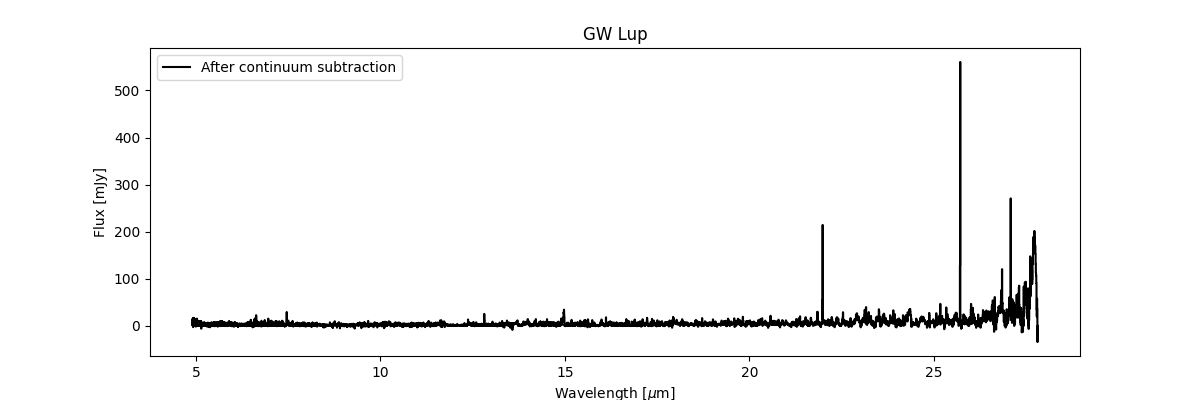

Text(0.5, 1.0, 'GW Lup')

In [25]:
spectra = np.loadtxt('../src/data/observations/GWLup.dat')
wavelength = spectra[:,0]
flux       = spectra[:,1]
continuum  = spectra[:,2]

fig,ax = plt.subplots(figsize=(12,4))

ax.step(wavelength,
        flux-continuum,
        where='mid',color='k',label='After continuum subtraction')

ax.legend(loc='upper left')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Flux [mJy]')
ax.set_title('GW Lup')

Zoom in and take a close look. This spectrum should appear quite distinct from that seen for a PDR. This is because, the emission features correspond to much more complex molecular emission (also including some of the atomic emission we investigated before).<br>

Here, we can make use of the slab models to identify the molecules. <br>

Below is an example of how to produce a slab model spectrum and plot it over the observed spectrum.

In [26]:
molecule = 'CO' # use the exact name as provided in the hitran directory
mol_mas = 28 # you need to know/find the molecular mass in atomic mass units. If you are not sure, search online or use online tools such as https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm
temperature = 800 # in Kelvin
column_density = 1e18 # in cm-2
isotopologue = [1] # let us select only the main isotopologue of the molecule
filepath = '../src/data/hitran/'+molecule+'.par' # path to the HITRAN spectroscopic data, DO NOT CHANGE UNLESS YOU WANT TO USE AN DIFFERENT DATA SET FOR THIS MOLECULE

data = runs.run_0D_slab(Ng         = column_density,  # The gas column density in molecules per cm2
                        Tg         = temperature,     # The gas temperature
                        vturb      = 2.0,             # Delta nu_D or the width parameter in km/s
                        molecule   = molecule,        # name of the molecule
                        mol_mass   = mol_mas,         # molecular mass in amu
                        HITRANfile = filepath,        # Path of the HITRAN data file
                        QTpath     = QTpath,          # path of the partition sums
                        isotopolog = isotopologue,    # list of isotopologues to include      
                        wave_mol   = [4.9,28],        # wavelength region in which the lines are to be picked up
                        mode       = 'line_by_line',  # "line-by-line" calculation, or include mutual "overlap"
                        output     = 'return')        # "return" data or write to "file" or do "both"

Then we read in the output, which contains the line strengths, and then convolve it to a spectral resolving power of R=3000, which is representative of the capabilities of JWST MIRI.<br>

As mentioned before, the output of the slab model is in the units erg/s/cm$^2$/sr/Hz. This can be converted to mJy/sr by multiplying 1e26, and to mJy by multiplying the solid angle that corresponds to the area of the planet-forming disk from which this emission arises. Essentially, this would be a scaling factor. <br>
The solid angle is given by,
$$\Delta\Omega = \frac{emitting\ area}{distance^2} = \frac{\pi R^2}{d^2}$$


 1 ; Model number  1 ; Species number  1


<IPython.core.display.Javascript object>


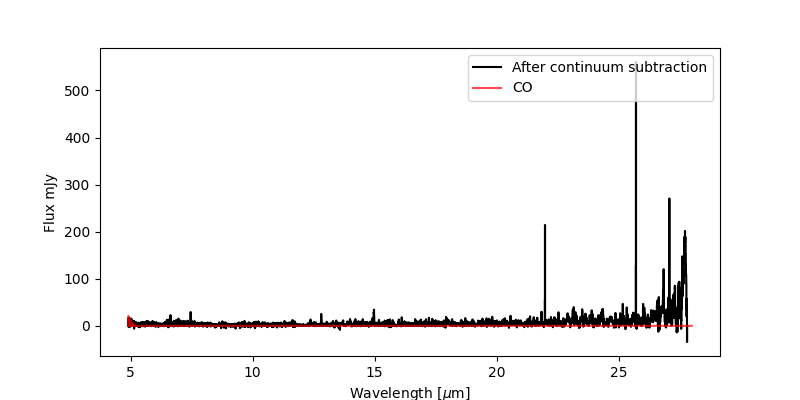

In [27]:
data.convolve(R=3000,lambda_0=4.9,lambda_n=28)

fig,ax = plt.subplots(figsize=(8,4))
ax.step(wavelength,
           flux-continuum,
           where='mid',color='k',label='After continuum subtraction')


slab_wavelength = data.convWavelength
solid_angle = np.pi*(0.125*au)**2/(155*pc)**2
slab_flux = data.convLTEflux*1e26*solid_angle

ax.plot(slab_wavelength,slab_flux,color='r',alpha=0.7,label=molecule)
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Flux mJy')
ax.legend(loc='upper right')

#### 2.2.1.1. Task 5
1) Identify as many molecules as you can in the spectrum. <br>
2) Play around with the temperatures, column densities and emitting area to see how they change and compare with the observations. Write down your best 'by-eye' estimates for each (or some) molecule(s). <br>
Finally, compare the list of molecules you identify and the temperatures, column densities, emitting radii with those reported in the published article <a href='https://ui.adsabs.harvard.edu/abs/2023ApJ...947L...6G/abstract'>Grant et al. (2023)</a>.

### 2.2.2. ISO-ChaI 147
Now, we move on to analyse an even more complex spectrum. This is from a disk around a very low-mass star, ISO-ChaI 147, which has a stellar mass of ~$0.11 M_{\odot}$ <a href='https://ui.adsabs.harvard.edu/abs/2024Sci...384.1086A/abstract'>(Arabhavi et al. 2024)</a>.<br>

Again like we did before, we remove the contribution from the dust, so that we can clearly analyze the gas emission.

<IPython.core.display.Javascript object>


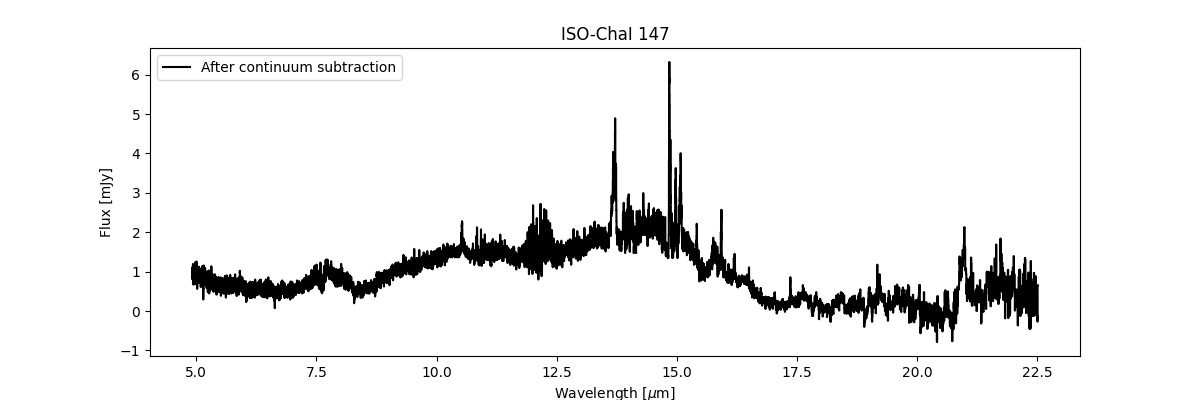

Text(0.5, 1.0, 'ISO-ChaI 147')

In [28]:
spectra = np.loadtxt('../src/data/observations/ISO-ChaI 147.dat')
wavelength = spectra[:,0]
flux       = spectra[:,1]
continuum  = spectra[:,2]

fig,ax = plt.subplots(figsize=(12,4))

ax.step(wavelength,
        flux-continuum,
        where='mid',color='k',label='After continuum subtraction')

ax.legend(loc='upper left')
ax.set_xlabel('Wavelength [$\mu$m]')
ax.set_ylabel('Flux [mJy]')
ax.set_title('ISO-ChaI 147')

#### 2.2.2.1 Task 6
Same as Task 5.<br>
1) Identify as many molecules as you can in the spectrum. <br>
2) Play around with the temperatures, column densities and emitting area to see how they change and compare with the observations. Write down your best 'by-eye' estimates for each (or some) molecule(s). <br>
Finally, compare the list of molecules you identify and the temperatures, column densities, emitting radii with those reported in the published article <a href='https://ui.adsabs.harvard.edu/abs/2024Sci...384.1086A/abstract'>Arabhavi et al. (2024)</a>.<br>


Hints:
1) CO and H$_2$O are in absorption at short wavelengths (<7 microns). Since the slab models we discussed before only produce emission spectra and not absorption spectra, simply plot the inverted slab model spectra.<br>
2) Most of the detected molecules contain carbon, large fraction of these are pure hydrocarbons.<br>
3) To reproduce some of the emission, you would need to add the flux from two slab models of the same molecule, one with very large column density ($\rm>10^{20}\ cm^{-2}$) and another with a lower column density.


Although the referred article proposes two components to the fit of some molecules, our slab models cannot reproduce that. What is missing? Think about one underlying assumption that is not mentioned when we built our slab models earlier in the exercise. (hint: think about what happens when two line are close in wavelengths, such that the line profiles overlap)<br>

How to accommodate for this effect?

That ends this exercise. Feel free to make notes below about the main take home points.